# Projet Neural Network - Corporación Favorita Grocery Sales Forecasting

Brick-and-mortar grocery stores are always in a delicate dance with purchasing and sales forecasting. Predict a little over, and grocers are stuck with overstocked, perishable goods. Guess a little under, and popular items quickly sell out, leaving money on the table and customers fuming.

The problem becomes more complex as retailers add new locations with unique needs, new products, ever transitioning seasonal tastes, and unpredictable product marketing. Corporación Favorita, a large Ecuadorian-based grocery retailer, knows this all too well. They operate hundreds of supermarkets, with over 200,000 different products on their shelves.

Corporación Favorita has challenged the Kaggle community to build a model that more accurately forecasts product sales. They currently rely on subjective forecasting methods with very little data to back them up and very little automation to execute plans. They’re excited to see how machine learning could better ensure they please customers by having just enough of the right products at the right time.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import random as rd
from tqdm import tqdm
import pandas as pd
import os
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from seasonal import *
from statsmodels.tsa.tsatools import *
from statsmodels.tsa.stattools import *
from statsmodels.tsa.tsatools import detrend
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
import itertools
import time

from neural_network import neural_net_model, neural_net_model_3layers, rnn_model

Using TensorFlow backend.


In [2]:
# Refer to the py file: "processing_data.py"
from processing_data import preprocessing

# One shop forecast

## I - Imports

/Users/louisgiron/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/Users/louisgiron/Desktop/ENSAE - Mastère spé/Reseaux de neurones/projet_nn/processing_data.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  train_small['unit_sales'] = train_small['unit_sales'].apply(lambda x:


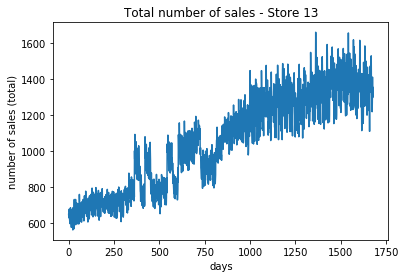

In [3]:
n = None
store_selection = 'yes'

train_all, test = preprocessing(n, store_selection)

# We are studying only one store, so the information about the city, the
# region are useless
train_all = train_all.drop(['id', 'store_nbr', 'city', 'state',
                       'cluster', 'type_x'], axis=1)
train_all = train_all.set_index('date')

In [4]:
print('Train - heads:')
print(train_all.head())
print()
print('---')
print('Train - shape:')
print(train_all.shape)

Train - heads:
            item_nbr  unit_sales onpromotion  dcoilwtico type_y locale  \
date                                                                     
2013-01-02    103501        13.0         NaN       93.14    NaN    NaN   
2013-01-02    105576        23.0         NaN       93.14    NaN    NaN   
2013-01-02    106716        11.0         NaN       93.14    NaN    NaN   
2013-01-02    108079         1.0         NaN       93.14    NaN    NaN   
2013-01-02    108701         4.0         NaN       93.14    NaN    NaN   

           locale_name description transferred     family  class  perishable  \
date                                                                           
2013-01-02         NaN         NaN         NaN   CLEANING   3008           0   
2013-01-02         NaN         NaN         NaN  GROCERY I   1045           0   
2013-01-02         NaN         NaN         NaN  GROCERY I   1032           0   
2013-01-02         NaN         NaN         NaN  GROCERY I   1030  

## II - Preprocessing of the data

### A - Missing data

In [5]:
# Explore and manage the missing data
print('Before missing values management:')
print('----')
missing = train_all.apply(lambda x: x.isnull().sum(), axis=0)
missing = pd.DataFrame(missing)
missing.columns = ["Number of missing values"]

# Share of missing
missing['Share of missing'] = round(missing['Number of missing values']/len(train_all)*100,2)
print(missing)

missing_rate = {}
for col in train_all.columns:
    missing_rate[col] = np.sum(train_all[col].isna())/len(train_all[col])

missing_rate_lim = 0.7

for key in missing_rate.keys():
    if missing_rate[key] > missing_rate_lim:
        train_all = train_all.drop([key], axis=1)

    if 0 < missing_rate[key] < missing_rate_lim:
        # Handle missing values - Use the mean strategy
        imp = SimpleImputer(missing_values=np.nan, strategy='mean')
        imp.fit(np.array(train_all[key]).reshape(-1, 1))
        temp_no_miss = imp.transform(np.array(train_all[key]).reshape(-1, 1))
        train_all[key] = temp_no_miss

print()
print('After missing values management:')
print('----')
# After the management
missing = train_all.apply(lambda x: x.isnull().sum(), axis=0)
missing = pd.DataFrame(missing)
missing.columns = ["Number of missing values"]

# Share of missing
missing['Share of missing'] = round(missing['Number of missing values']/len(train_all)*100,2)
print(missing)

Before missing values management:
----
              Number of missing values  Share of missing
item_nbr                             0              0.00
unit_sales                           0              0.00
onpromotion                     328608             18.92
dcoilwtico                      571192             32.89
type_y                         1469736             84.63
locale                         1469736             84.63
locale_name                    1469736             84.63
description                    1469736             84.63
transferred                    1469736             84.63
family                               0              0.00
class                                0              0.00
perishable                           0              0.00
transactions                      4156              0.24

After missing values management:
----
              Number of missing values  Share of missing
item_nbr                             0               0.0
unit_sales

In [6]:
print('Train - heads:')
print(train_all.head())
print()
print('---')
print('Train - shape:')
print(train_all.shape)

Train - heads:
            item_nbr  unit_sales  onpromotion  dcoilwtico     family  class  \
date                                                                          
2013-01-02    103501        13.0     0.073756       93.14   CLEANING   3008   
2013-01-02    105576        23.0     0.073756       93.14  GROCERY I   1045   
2013-01-02    106716        11.0     0.073756       93.14  GROCERY I   1032   
2013-01-02    108079         1.0     0.073756       93.14  GROCERY I   1030   
2013-01-02    108701         4.0     0.073756       93.14       DELI   2644   

            perishable  transactions  
date                                  
2013-01-02           0        1102.0  
2013-01-02           0        1102.0  
2013-01-02           0        1102.0  
2013-01-02           0        1102.0  
2013-01-02           1        1102.0  

---
Train - shape:
(1736728, 8)


### B - Categorical Variables

In [7]:
# Categorical variables
# family is a category
family = train_all[['family', 'unit_sales']]
family = family.groupby(['family'], as_index=False)['unit_sales'].count()
family.columns = ['family', 'count']
family['repartition_percent'] = family['count']/np.sum(family['count'])*100
family = family.sort_values(by=['count'], ascending=False)
family.reset_index(inplace=True)
family = family.drop('index', axis=1)
print(family)

selection = list(family['family'].loc[:3])

# Nous gardons les 4 premieres categories (choix arbitraire) et créeons une catégorie other
def family_transform(x, selection=selection):
    if x in selection:
        return x
    else:
        return 'other'


train_all['family'] = train_all['family'].apply(family_transform)
train_all = pd.get_dummies(train_all)

print(train_all.columns)

                        family   count  repartition_percent
0                    GROCERY I  717811            41.331227
1                     CLEANING  271739            15.646607
2                    BEVERAGES  262877            15.136337
3                        DAIRY  101349             5.835629
4                PERSONAL CARE   63478             3.655034
5                         DELI   61163             3.521737
6                    HOME CARE   46274             2.664436
7                 BREAD/BAKERY   43239             2.489682
8                      PRODUCE   38688             2.227637
9                        MEATS   23499             1.353062
10                     POULTRY   19697             1.134144
11                        EGGS   14771             0.850507
12                FROZEN FOODS   14109             0.812390
13            LIQUOR,WINE,BEER   12392             0.713526
14              PREPARED FOODS    8088             0.465703
15         HOME AND KITCHEN II    6667  

### C - Data Set transformation

#### Transform the time series in handling dataset

In [8]:
def series_to_supervised(data, shift_window_past, value_to_predict, shift_window_future=0):
    """
    Input:
    -----
    data: Pandas DF
    shift_window_past: number of shifts in the past
    shift_window_future: 
    """
    name_var = data.columns
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(shift_window_past, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (name, i)) for name in name_var]
        
    # Value to predict at t
    val = data[value_to_predict]
    cols.append(val)
    names.append(str(value_to_predict) + '(t)')
    
    if shift_window_future > 0:
        # forecast sequence (t, t+1, ... t+n)
        for i in range(1, shift_window_future+1):
            cols.append(data.shift(-i))
            if i == 0:
                names += [('%s(t)' % (name)) for name in name_var]
            else:
                names += [('%s(t+%d)' % (name, i)) for name in name_var]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values (erase the first shift_window_past rows)
    agg.dropna(inplace=True)
    return agg

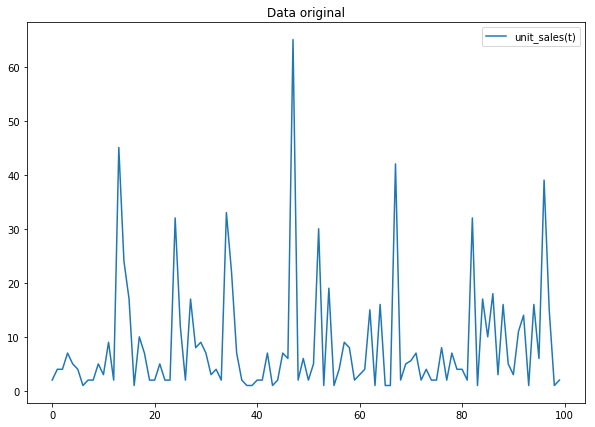

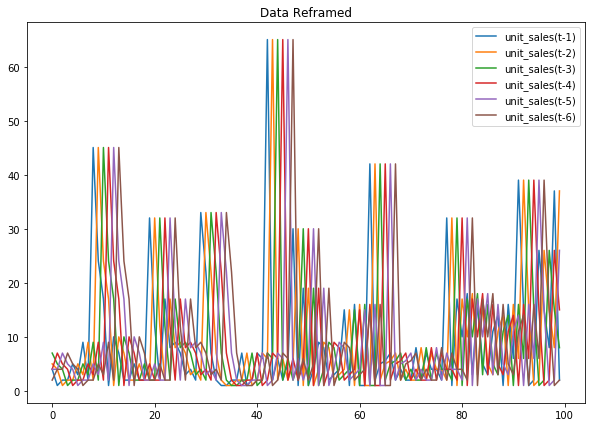

In [9]:
# load dataset
dataset = train_all.copy()

# ensure all data is float
dataset = dataset.astype('float32')

# frame as supervised learning
shift_window_past = 6
value_to_predict = 'unit_sales'
shift_window_future=0
reframed = series_to_supervised(dataset, shift_window_past, value_to_predict, shift_window_future=0)

# Visualisation
plt.figure(figsize=(10, 7))
plt.plot(list(dataset['unit_sales'])[500:600], label='unit_sales(t)')
plt.title('Data original')
plt.legend()
plt.show()

plt.figure(figsize=(10, 7))
for i in range(1, shift_window_past+1):
    plt.plot(list(reframed[('unit_sales(t-%d)' % (i))])[500:600], label=('unit_sales(t-%d)' % (i)))
plt.title('Data Reframed')
plt.legend()
plt.show()

In [10]:
reframed.head()

,item_nbr(t-6),unit_sales(t-6),onpromotion(t-6),dcoilwtico(t-6),class(t-6),perishable(t-6),transactions(t-6),family_BEVERAGES(t-6),family_CLEANING(t-6),family_DAIRY(t-6),...,dcoilwtico(t-1),class(t-1),perishable(t-1),transactions(t-1),family_BEVERAGES(t-1),family_CLEANING(t-1),family_DAIRY(t-1),family_GROCERY I(t-1),family_other(t-1),unit_sales(t)
date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,103501.0,13.0,0.073757,93.139999,3008.0,0.0,1102.0,0.0,1.0,0.0,...,93.139999,3044.0,0.0,1102.0,0.0,1.0,0.0,0.0,0.0,1.0
2013-01-02,105576.0,23.0,0.073757,93.139999,1045.0,0.0,1102.0,0.0,0.0,0.0,...,93.139999,1004.0,0.0,1102.0,0.0,0.0,0.0,1.0,0.0,1.0
2013-01-02,106716.0,11.0,0.073757,93.139999,1032.0,0.0,1102.0,0.0,0.0,0.0,...,93.139999,2502.0,1.0,1102.0,0.0,0.0,0.0,0.0,1.0,1.0
2013-01-02,108079.0,1.0,0.073757,93.139999,1030.0,0.0,1102.0,0.0,0.0,0.0,...,93.139999,3024.0,0.0,1102.0,0.0,1.0,0.0,0.0,0.0,29.0
2013-01-02,108701.0,4.0,0.073757,93.139999,2644.0,1.0,1102.0,0.0,0.0,0.0,...,93.139999,1034.0,0.0,1102.0,0.0,0.0,0.0,1.0,0.0,2.0


In [11]:
print('Original set shape:')
print('----')
print(dataset.shape)
print()
print('Reframed set shape: (with shift_window = ' + str(shift_window_past) + ')')
print('----')
print(reframed.shape)

Original set shape:
----
(1736728, 12)

Reframed set shape: (with shift_window = 6)
----
(1736722, 73)


### D - Fearture importance

In [12]:
# Feature importance
X = reframed.drop(['unit_sales(t)'], axis=1).copy()
y = reframed['unit_sales(t)'].copy()

features = X.columns

print('Shape of X:', X.shape)
print('Shape of y:', y.shape)

Shape of X: (1736722, 72)
Shape of y: (1736722,)


In [13]:
# Model Lasso for feature selection
clf = LassoCV(cv=5)
clf = clf.fit(np.array(X), np.array(y))

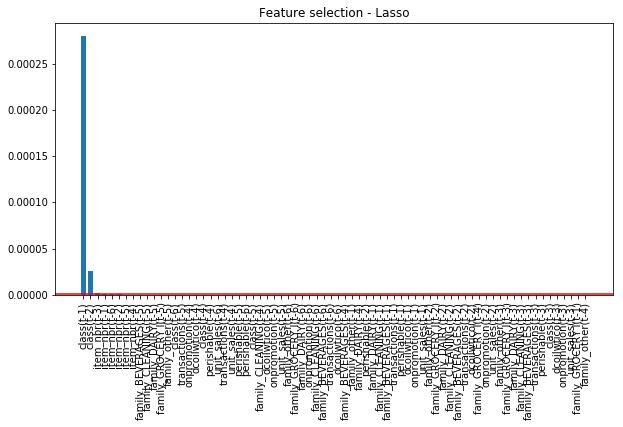

In [14]:
# Visualisation of the result
res_lasso = np.abs(clf.coef_)
index_sort = np.argsort(res_lasso)[::-1]

feature_sort = list(features[index_sort])
res_lasso_sort = res_lasso[index_sort]
treshold = 10**-6

fig = plt.figure(figsize=(10, 5))
plt.bar(np.arange(0, len(feature_sort)), res_lasso_sort)
plt.axhline(y=treshold, color='r', linestyle='-')
plt.xticks(np.arange(0, len(feature_sort)), feature_sort, rotation='vertical')
plt.title('Feature selection - Lasso')
plt.show()

In [15]:
# Treshold
treshold = 0

model = SelectFromModel(clf, threshold=treshold, prefit=True)
feature_selected_index = model.get_support(indices=True)

print('Feature selected:')
print(features[feature_selected_index])

# selection
value_to_predict = 'unit_sales(t)'
selection = list(features[feature_selected_index])
selection.append(value_to_predict)

Feature selected:
Index(['item_nbr(t-6)', 'unit_sales(t-6)', 'onpromotion(t-6)',
       'dcoilwtico(t-6)', 'class(t-6)', 'perishable(t-6)', 'transactions(t-6)',
       'family_BEVERAGES(t-6)', 'family_CLEANING(t-6)', 'family_DAIRY(t-6)',
       'family_GROCERY I(t-6)', 'family_other(t-6)', 'item_nbr(t-5)',
       'unit_sales(t-5)', 'onpromotion(t-5)', 'dcoilwtico(t-5)', 'class(t-5)',
       'perishable(t-5)', 'transactions(t-5)', 'family_BEVERAGES(t-5)',
       'family_CLEANING(t-5)', 'family_DAIRY(t-5)', 'family_GROCERY I(t-5)',
       'family_other(t-5)', 'item_nbr(t-4)', 'unit_sales(t-4)',
       'onpromotion(t-4)', 'dcoilwtico(t-4)', 'class(t-4)', 'perishable(t-4)',
       'transactions(t-4)', 'family_BEVERAGES(t-4)', 'family_CLEANING(t-4)',
       'family_DAIRY(t-4)', 'family_GROCERY I(t-4)', 'family_other(t-4)',
       'item_nbr(t-3)', 'unit_sales(t-3)', 'onpromotion(t-3)',
       'dcoilwtico(t-3)', 'class(t-3)', 'perishable(t-3)', 'transactions(t-3)',
       'family_BEVERAGES(t-

### E - Final train set

In [16]:
train_all_processed = reframed[selection]

print('X train original shape:', reframed.shape)
print('X train processed shape:', train_all_processed.shape)

X train original shape: (1736722, 73)
X train processed shape: (1736722, 73)


## III - Training setup

In [17]:
# Train size
value_to_predict = 'unit_sales(t)'
train_size_ratio = 0.6
valid_train_size_ratio = 0.1

# Normalize train X
data_X = train_all_processed.drop([value_to_predict], axis=1)
data_y = train_all_processed[value_to_predict]

scaler = MinMaxScaler(feature_range=(0, 1))
data_X_norm = scaler.fit_transform(data_X)
data_y_norm = scaler.fit_transform(np.array(data_y).reshape(-1, 1))

# Definition of train, valid and test
size = train_all_processed.shape[0]

train_set = np.arange(0, int(train_size_ratio*size))
valid_set = np.arange(int(train_size_ratio*size), int(train_size_ratio*size)
                      + int(valid_train_size_ratio*size))
test_set = np.arange(int(train_size_ratio*size+valid_train_size_ratio*size),
                     int(size))

# Split the train data to learn # Warning date -> split linearly
X_train = data_X_norm[train_set, :]
y_train = data_y_norm[train_set]
X_valid = data_X_norm[valid_set, :]
y_valid = data_y_norm[valid_set]
X_test = data_X_norm[test_set, :]
y_test = data_y_norm[test_set]

print('X train shape:', X_train.shape)
print('X valid shape:', X_valid.shape)
print('X test shape:', X_test.shape)

def denormalize(y_train, norm_data):
    try:
        df = y_train.values.reshape(-1, 1)
    except AttributeError:
        df = y_train.reshape(-1, 1)
    norm_data = norm_data.reshape(-1, 1)
    scl = MinMaxScaler()
    scl.fit_transform(df)
    return scl.inverse_transform(norm_data)

/Users/louisgiron/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


X train shape: (1042033, 72)
X valid shape: (173672, 72)
X test shape: (521017, 72)


## IV - Reccurent neural network - Tensorflow

### A - Model initialization

#### Input data

In [18]:
# Dataset reshaped
X_train = data_X_norm[train_set, :]
y_train = data_y_norm[train_set]
X_valid = data_X_norm[valid_set, :]
y_valid = data_y_norm[valid_set]
X_test = data_X_norm[test_set, :]
y_test = data_y_norm[test_set]

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_valid = X_valid.reshape((X_valid.shape[0], 1, X_valid.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print('Train:')
print('----')
print(X_train.shape, y_train.shape)
print()
print('Valid:')
print('----')
print(X_valid.shape, y_valid.shape)
print()
print('Test:')
print('----')
print(X_test.shape, y_test.shape)

Train:
----
(1042033, 1, 72) (1042033, 1)

Valid:
----
(173672, 1, 72) (173672, 1)

Test:
----
(521017, 1, 72) (521017, 1)


#### Graph definition - Hyperparameters research

In [27]:
def GridSearchRNN(window_size, nb_epoch, batch_size, X_train=X_train, y_train=y_train,
                  X_test=X_test, y_test=y_test):

    # design network
    model = Sequential()
    model.add(LSTM(window_size, input_shape=(X_train.shape[1], X_train.shape[2]))) # compute window size
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    # fit network
    history = model.fit(X_train, y_train, epochs=nb_epoch, batch_size=batch_size,
                        validation_data=(X_valid, y_valid), verbose=0, shuffle=False)
    
    # make a prediction
    yhat = model.predict(X_test)

    # invert scaling for forecast & original
    pred = denormalize(data_y, yhat)
    real = denormalize(data_y, y_test)
    rmse = np.sqrt(mean_squared_error(pred, real))
    
    # Rescale the prediction between 0 and 1 - Under scaled predictions
    scaler_pred = MinMaxScaler(feature_range=(0, max(y_test)))
    scaler_fitted_pred = scaler_pred.fit(np.abs(yhat))
    yhat_scaled = scaler_fitted_pred.transform(np.abs(yhat))
    pred_rescaled = denormalize(data_y, yhat_scaled)
    rmse_rescaled = np.sqrt(mean_squared_error(pred_rescaled, real))
    
    return rmse, rmse_rescaled, pred, pred_rescaled, real, history

#### Hyperparameters initialisation

In [28]:
window_size = [5, 20]
nb_epoch = [10]
batch_size = [200, 500]

print('Total grid search:', len(window_size)*len(nb_epoch)*len(batch_size), 'iterations')
print(window_size)
print(nb_epoch)
print(batch_size)

Total grid search: 4 iterations
[5, 20]
[10]
[200, 500]


In [29]:
best_param = [] 
rmse = []
rmse_rescaled = []
pred = []
pred_rescaled = []
val_loss = []
train_loss = []
real = []
j = 0

start = time.time()

for size, epoch, batch in tqdm(itertools.product(window_size, nb_epoch, batch_size)):
    start_sub = time.time()
    rmse_, rmse_rescaled_, pred_, pred_rescaled_, real_, history = GridSearchRNN(size, epoch, batch)
    rmse.append(rmse_)
    rmse_rescaled.append(rmse_rescaled_)
    pred.append(pred_)
    pred_rescaled.append(pred_rescaled_)
    real.append(real_)
    best_param.append((size, epoch, batch))
    val_loss.append(history.history['val_loss'])
    train_loss.append(history.history['loss'])
    j += 1
    print('----')
    print('Iteration:', j)
    print('Executed in:', round((time.time()-start_sub)/60, 2), 'min')
    print('RMSE:', rmse_)
    print('RMSE rescaled predictions:', rmse_rescaled_)
    print()

print('Execution time:', round((time.time()-start)/60, 2), 'min')

1it [08:24, 504.35s/it]

----
Iteration: 1
Executed in: 8.41 min
RMSE: 10.70599
RMSE rescaled predictions: 72.81391



2it [12:21, 424.18s/it]

----
Iteration: 2
Executed in: 3.95 min
RMSE: 10.745894
RMSE rescaled predictions: 288.62714



3it [20:52, 450.36s/it]

----
Iteration: 3
Executed in: 8.52 min
RMSE: 10.692207
RMSE rescaled predictions: 75.53517



4it [24:58, 388.91s/it]

----
Iteration: 4
Executed in: 4.09 min
RMSE: 10.746315
RMSE rescaled predictions: 283.3904

Execution time: 24.97 min


#### Best model

In [30]:
best_ = np.argsort(rmse)[0]
best_param_ = best_param[best_]
best_pred_ = pred[best_]
best_pred_rescaled_ = pred_rescaled[best_]
real_ = real[best_]
val_loss_ = val_loss[best_]
loss_ = train_loss[best_]

print('Best param:', best_param_)
print('RMSE:', rmse[best_])
print('RMSE rescaled predictions:', rmse_rescaled[best_])

Best param: (20, 10, 200)
RMSE: 10.692207
RMSE rescaled predictions: 75.53517


### C - Visualization

#### Cost of the prediction

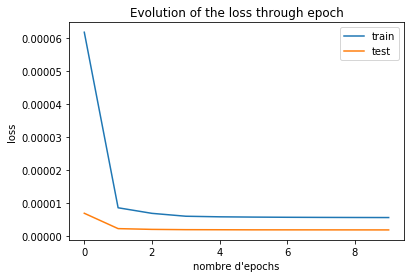

In [31]:
# plot history
plt.plot(loss_, label='train')
plt.plot(val_loss_, label='test')
plt.title('Evolution of the loss through epoch')
plt.xlabel("nombre d'epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

#### Predictions against original values

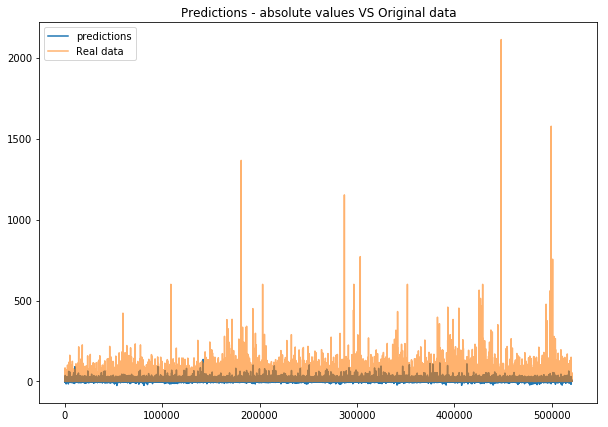

In [32]:
# Comparaison - Non-scaled data
plt.figure(figsize=(10, 7))
plt.plot(best_pred_, label='predictions')
plt.plot(real_, label='Real data', alpha=0.6)
plt.title('Predictions - absolute values VS Original data')
plt.legend()
plt.show()

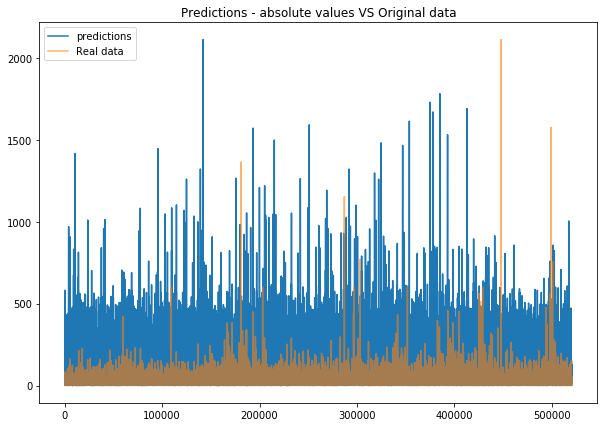

In [33]:
# Comparaison - yhat rescaled between 0 and 1 after prediction
plt.figure(figsize=(10, 7))
plt.plot(best_pred_rescaled_, label='predictions')
plt.plot(real_, label='Real data', alpha=0.6)
plt.title('Predictions - absolute values VS Original data')
plt.legend()
plt.show()